In [1]:
import numpy as np
import pickle
import itertools
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision import transforms
from SegDataset import SegmentationDataset
from einops import rearrange
from transformers import AdamW, SegformerForSemanticSegmentation
import matplotlib.pyplot as plt
import random

import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.utils.data import DataLoader

/home/mpham/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

Config

In [3]:
DATASET_DIRECTORY = "ml-mangrove-data/"
#PRETRAINED_MODEL_NAME = "nvidia/segformer-b5-finetuned-cityscapes-1024-1024" #alternative pretrained_model_name = "nvidia/mit-b5"
PRETRAINED_MODEL_NAME ="./segformer-b5-finetuned-mangrove-128-128/" 


DEVICE = "cuda" if torch.cuda.is_available() else "cpu" #device to be used for training and evaluation
PIN_MEMORY = True if DEVICE == "cuda" else False #if we will be pinning memory during data loading

INPUT_IMAGE_WIDTH = 128 #or 256
INPUT_IMAGE_HEIGHT = 128
NUM_CHANNELS = 9
NUM_CLASSES = 1

TEST_SPLIT = 0.10
PERCENT_NOMANGROVE_TILE_KEEP = 0.2
BATCH_SIZE = 32
INIT_LR = 0.0001 #0.0001 #0.00006
LOSS_FUNCTION = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.0, 4.0]))
NUM_EPOCHS = 25
TEST_EVAL_EVERY_BATCH = 5 #how frequently to compute/save/display test accuracy, must be non-zero positive

EARLY_STOPPER_PATIENCE = 3 #how many epochs of lower test set accuracy before early stopping (also dependent on delta)
EARLY_STOPPER_DELTA = 0 #how much test set accuracy needs to drop before early stopping (also dependent on patience)

Read Files

In [4]:
#read data from https://www.kaggle.com/datasets/stanleydil/e4e-jamaica-segmentation-dataset by read from kaggle
with open(DATASET_DIRECTORY + '128px_images.pkl', 'rb') as handle:
    images = pickle.load(handle)

with open(DATASET_DIRECTORY + '128px_labels.pkl', 'rb') as handle:
    labels = pickle.load(handle)

with open(DATASET_DIRECTORY + '128_mlabels.pkl', 'rb') as handle:
    m_tiles = pickle.load(handle)

Data Preprocessing

In [5]:
#rearrange dimensions of images and labels
images = np.array(images)
images = rearrange(images, "b w h c -> b c w h")

labels = np.array(labels)
labels = rearrange(labels, "b w h c -> b c w h")
labels = np.squeeze(labels, axis=1)

print(f'input shape (b x c x w x h): {images.shape}')
print(f'label shape (b x [squeezed 1 channel] x w x h): {labels.shape}')

input shape (b x c x w x h): (4092, 9, 128, 128)
label shape (b x [squeezed 1 channel] x w x h): (4092, 128, 128)


In [6]:
# mask_sums = labels.sum(axis=(1, 2))

# # Boolean indexing to keep only non-empty masks and images
# non_empty_indices = mask_sums > 0
# images = images[non_empty_indices]
# labels = labels[non_empty_indices]

In [7]:
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
trainImages, testImages, trainMasks, testMasks = train_test_split(images, labels, #images, labels,
                         test_size=TEST_SPLIT, random_state=42)

#systemic undersampling of 0 class
mask_sums = trainMasks.sum(axis=(1, 2))
non_empty_indices = mask_sums > 0

non_empty_indices_ls = non_empty_indices.tolist()
non_empty_indices = []
for element in non_empty_indices_ls:
    if element == False:
        if random.random() < PERCENT_NOMANGROVE_TILE_KEEP:
            non_empty_indices.append(True)
        else:
            non_empty_indices.append(False)
    else:
          non_empty_indices.append(True)

trainImages = trainImages[non_empty_indices]
trainMasks = trainMasks[non_empty_indices]


# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize((INPUT_IMAGE_HEIGHT,
                                                    INPUT_IMAGE_WIDTH)),
                                 transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(images=trainImages, labels=trainMasks, transforms = transforms)
                              #transforms=transforms)
testDS = SegmentationDataset(images=testImages, labels=testMasks, transforms = transforms)
                             #transforms=transforms)
print(f"found {len(trainDS)} examples in the training set.")
print(f"found {len(testDS)} examples in the test set.")
# create the training and test data loaders #config
trainLoader = DataLoader(trainDS, shuffle=True,
                         batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                         num_workers=0) #os.cpu_count()
testLoader = DataLoader(testDS, shuffle=False,
                        batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                        num_workers=0) #os.cpu_count()

found 1544 examples in the training set.
found 410 examples in the test set.


In [8]:
# assign the human-readable labels to encoding, encoding to human-readable labels
id2label = {
    0: "nomangrove",
    1: "mangrove"
}

label2id = {
    "nomangrove": 0,
    "mangrove": 1
}

Initialize Model

In [9]:
# Load the pretrained model
model = SegformerForSemanticSegmentation.from_pretrained(
    PRETRAINED_MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    num_labels = 2
)

# Modify the first layer to match the number of channels in data
modified_layer = nn.Conv2d(NUM_CHANNELS, 64, kernel_size=7, stride=4, padding=3)
model.segformer.encoder.patch_embeddings[0].proj = modified_layer

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at ./segformer-b5-finetuned-mangrove-128-128/ and are newly initialized because the shapes did not match:
- segformer.encoder.patch_embeddings.0.proj.weight: found shape torch.Size([64, 9, 7, 7]) in the checkpoint and torch.Size([64, 3, 7, 7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
print(model)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(9, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

Helper Classes

In [11]:
batch = next(iter(trainLoader))
test_batch = itertools.cycle(testLoader)

In [12]:
optimizer = AdamW(model.parameters(), lr=INIT_LR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

/home/mpham/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model Initialized!


In [13]:
class Early_stopper: #early stopper class -> move to py file
    def __init__(self):
        self.patience = EARLY_STOPPER_PATIENCE
        self.delta = EARLY_STOPPER_DELTA
        self.patience_counter = 0
        self.min_test_loss = np.inf
    def check_stop(self, test_loss):
        if self.min_test_loss > test_loss:
            self.patience_counter = 0
            self.min_test_loss = test_loss
        elif test_loss > (self.min_test_loss + self.delta):
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                return True
        return False

In [14]:
class Total_updater:
  def __init__(self):
    self.test_epoch = [] 
    self.test_acc = [] 
    self.test_avr_acc = [] 
    self.test_loss = [] 
    self.test_avr_loss = [] 
    self.test_avr_acc_epoch = []
    self.test_avr_loss_epoch = []
    self.tests_count = 0 
    self.tests_epoch_count = 0 

    self.train_epoch = []
    self.train_acc = []
    self.train_avr_acc = []
    self.train_loss = []
    self.train_avr_loss = []
    self.train_avr_acc_epoch = []
    self.train_avr_loss_epoch = []
    self.trains_count = 0
    self.trains_epoch_count = 0


    self.epoch_test_acc_cum = 0 #use
    self.total_test_acc_cum = 0 #use
    self.epoch_test_loss_cum = 0 #use
    self.total_test_loss_cum = 0 #use

    self.epoch_train_acc_cum = 0
    self.total_train_acc_cum = 0
    self.epoch_train_loss_cum = 0
    self.total_train_loss_cum = 0

    self.epoch = 0
  def update_test(self, acc, loss):
    self.tests_count += 1
    self.tests_epoch_count += 1
    self.test_epoch.append(self.epoch + TEST_EVAL_EVERY_BATCH * self.tests_epoch_count/(len(trainDS) // BATCH_SIZE + 1 ))#self.epoch + (self.tests_epoch_count-1)/self.tests_epoch_count)

    self.test_acc.append(acc)
    self.test_acc.append(loss)

    self.epoch_test_acc_cum += acc
    self.total_test_acc_cum += acc
    self.epoch_test_loss_cum += loss
    self.total_test_loss_cum += loss

    self.test_avr_acc.append(self.total_test_acc_cum/self.tests_count)
    self.test_avr_loss.append(self.total_test_loss_cum/self.tests_count)

  def update_train(self, acc, loss):
    self.trains_count += 1
    self.trains_epoch_count += 1
    self.train_epoch.append(self.epoch + self.trains_epoch_count/(len(trainDS) // BATCH_SIZE + 1 )) #(self.epoch + (self.trains_epoch_count-1)/self.trains_epoch_count)

    self.train_acc.append(acc)
    self.train_acc.append(loss)

    self.epoch_train_acc_cum += acc
    self.total_train_acc_cum += acc
    self.epoch_train_loss_cum += loss
    self.total_train_loss_cum += loss

    self.train_avr_acc.append(self.total_train_acc_cum/self.trains_count)
    self.train_avr_loss.append(self.total_train_loss_cum/self.trains_count)


  def reset_epoch(self):
    self.test_avr_acc_epoch.append(self.epoch_test_acc_cum/self.tests_epoch_count)
    self.test_avr_loss_epoch.append(self.epoch_test_loss_cum/self.tests_epoch_count)

    self.train_avr_acc_epoch.append(self.epoch_train_acc_cum/self.trains_epoch_count)
    self.train_avr_loss_epoch.append(self.epoch_train_loss_cum/self.trains_epoch_count)
    
    print(f"EPOCH {self.epoch} Avr Test Accuracy: {self.test_avr_acc_epoch[self.epoch]}\
         Avr Test Loss: {self.test_avr_loss_epoch[self.epoch]}\
         Avr Train Accuracy: {self.train_avr_acc_epoch[self.epoch]}\
         Avr Train Loss: {self.train_avr_loss_epoch[self.epoch]}")
    
    
    self.epoch_test_acc_cum = 0
    self.epoch_test_loss_cum = 0
    self.epoch_train_acc_cum = 0
    self.epoch_train_loss_cum = 0

    self.tests_epoch_count = 0
    self.trains_epoch_count = 0

    self.epoch += 1



In [15]:
early_stopper = Early_stopper()
total_updater = Total_updater()

Train

In [16]:
for epoch in range(NUM_EPOCHS):
    print("Epoch:", epoch)
    pbar = tqdm(trainLoader)
    model.train()
    
    total_train_set = []
    for idx, batch in enumerate(pbar):
        batch_index = idx

        # get the inputs
        pixel_values = batch[0].to(device)
        labels = batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)

        #train set eval
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)
        mask = (labels != -1) # don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        loss = outputs.loss


        logits_flat = upsampled_logits.reshape(-1, 2)  # Reshape logits to [batch_size * height * width, num_classes]
        labels_one_hot = nn.functional.one_hot(labels.view(-1), num_classes=2)
        loss_fn = LOSS_FUNCTION.cuda()
        bce_loss = loss_fn(logits_flat, labels_one_hot.float())


        total_updater.update_train(accuracy, loss.item())
        pbar.set_postfix({'Batch': idx, 'Batch Train Accuracy': accuracy, 'Train Loss': loss.item()})

        #test set eval
        if idx//TEST_EVAL_EVERY_BATCH == idx/TEST_EVAL_EVERY_BATCH:
            model.eval()
            next_test_batch = next(test_batch)
            test_pixel_values = next_test_batch[0].to(device)
            test_labels = next_test_batch[1].to(device)
            test_outputs = model(pixel_values=test_pixel_values, labels=test_labels)
            test_upsampled_logits = nn.functional.interpolate(test_outputs.logits, size=test_labels.shape[-2:], mode="bilinear", align_corners=False)
            test_predicted = test_upsampled_logits.argmax(dim=1)
            test_mask = (test_labels != -1) # don't include the background class in the accuracy calculation
            test_pred_labels = test_predicted[test_mask].detach().cpu().numpy()
            test_true_labels = test_labels[test_mask].detach().cpu().numpy()
            test_accuracy = accuracy_score(test_pred_labels, test_true_labels)
            test_loss = test_outputs.loss

            total_updater.update_test(test_accuracy, test_loss.item())
            
            print(f'Batch Test Accuracy: {test_accuracy}, Test Loss: {test_loss.item()}')
            model.train()


        # backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         

    total_updater.reset_epoch()

    #early stopping
    test_loss_epoch = total_updater.test_avr_loss_epoch[total_updater.epoch-1]
    if early_stopper.check_stop(test_loss_epoch):             
        break

Epoch: 0


  0%|          | 0/49 [00:08<?, ?it/s, Batch=0, Batch Train Accuracy=0.706, Train Loss=1.93]

Batch Test Accuracy: 0.91363525390625, Test Loss: 0.8645469546318054


 12%|█▏        | 6/49 [00:24<02:26,  3.40s/it, Batch=5, Batch Train Accuracy=0.742, Train Loss=0.802]

Batch Test Accuracy: 0.8741569519042969, Test Loss: 0.23944464325904846


 22%|██▏       | 11/49 [00:35<01:34,  2.47s/it, Batch=10, Batch Train Accuracy=0.783, Train Loss=0.532]

Batch Test Accuracy: 0.7309226989746094, Test Loss: 0.6045500636100769


 33%|███▎      | 16/49 [00:44<01:05,  1.97s/it, Batch=15, Batch Train Accuracy=0.749, Train Loss=0.858]

Batch Test Accuracy: 0.9506015777587891, Test Loss: 0.1204291582107544


 43%|████▎     | 21/49 [00:54<00:59,  2.14s/it, Batch=20, Batch Train Accuracy=0.798, Train Loss=0.489]

Batch Test Accuracy: 0.7345771789550781, Test Loss: 0.6004297137260437


 53%|█████▎    | 26/49 [01:02<00:46,  2.04s/it, Batch=25, Batch Train Accuracy=0.808, Train Loss=0.413]

Batch Test Accuracy: 0.7569465637207031, Test Loss: 0.34977373480796814


 63%|██████▎   | 31/49 [01:12<00:36,  2.02s/it, Batch=30, Batch Train Accuracy=0.753, Train Loss=0.501]

Batch Test Accuracy: 0.21921348571777344, Test Loss: 0.8405932188034058


 73%|███████▎  | 36/49 [01:19<00:22,  1.73s/it, Batch=35, Batch Train Accuracy=0.761, Train Loss=0.542]

Batch Test Accuracy: 0.8939037322998047, Test Loss: 0.33371683955192566


 84%|████████▎ | 41/49 [01:27<00:13,  1.65s/it, Batch=40, Batch Train Accuracy=0.745, Train Loss=0.446]

Batch Test Accuracy: 0.8993358612060547, Test Loss: 0.17922094464302063


 92%|█████████▏| 45/49 [01:32<00:04,  1.10s/it, Batch=45, Batch Train Accuracy=0.802, Train Loss=0.443]

Batch Test Accuracy: 0.9300670623779297, Test Loss: 0.16246961057186127


100%|██████████| 49/49 [01:39<00:00,  2.03s/it, Batch=48, Batch Train Accuracy=0.839, Train Loss=0.411]


EPOCH 0 Avr Test Accuracy: 0.7903360366821289         Avr Test Loss: 0.429517488181591         Avr Train Accuracy: 0.7638741707315251         Avr Train Loss: 0.6248741794605644
Epoch: 1


  0%|          | 0/49 [00:03<?, ?it/s, Batch=0, Batch Train Accuracy=0.822, Train Loss=0.368]

Batch Test Accuracy: 0.9110298156738281, Test Loss: 0.19119542837142944


 10%|█         | 5/49 [00:11<01:17,  1.76s/it, Batch=5, Batch Train Accuracy=0.825, Train Loss=0.353]

Batch Test Accuracy: 0.9239330291748047, Test Loss: 0.14842471480369568


 20%|██        | 10/49 [00:21<01:11,  1.83s/it, Batch=10, Batch Train Accuracy=0.826, Train Loss=0.389]

Batch Test Accuracy: 0.93365478515625, Test Loss: 0.2403111755847931


 31%|███       | 15/49 [00:28<00:47,  1.38s/it, Batch=15, Batch Train Accuracy=0.85, Train Loss=0.327] 

Batch Test Accuracy: 0.9384822845458984, Test Loss: 0.12766839563846588


 41%|████      | 20/49 [00:35<00:37,  1.30s/it, Batch=20, Batch Train Accuracy=0.829, Train Loss=0.33] 

Batch Test Accuracy: 0.8719005584716797, Test Loss: 0.21992270648479462


 53%|█████▎    | 26/49 [00:43<00:33,  1.44s/it, Batch=25, Batch Train Accuracy=0.814, Train Loss=0.362]

Batch Test Accuracy: 0.9313392639160156, Test Loss: 0.13491392135620117


 63%|██████▎   | 31/49 [00:49<00:27,  1.53s/it, Batch=30, Batch Train Accuracy=0.856, Train Loss=0.348]

Batch Test Accuracy: 0.9458847045898438, Test Loss: 0.09759853035211563


 73%|███████▎  | 36/49 [00:57<00:19,  1.48s/it, Batch=35, Batch Train Accuracy=0.864, Train Loss=0.306]

Batch Test Accuracy: 0.9314899444580078, Test Loss: 0.13827772438526154


 84%|████████▎ | 41/49 [01:03<00:11,  1.47s/it, Batch=40, Batch Train Accuracy=0.801, Train Loss=0.382]

Batch Test Accuracy: 0.9479732513427734, Test Loss: 0.12062250077724457


 94%|█████████▍| 46/49 [01:10<00:04,  1.36s/it, Batch=45, Batch Train Accuracy=0.816, Train Loss=0.399]

Batch Test Accuracy: 0.9583225250244141, Test Loss: 0.10197576880455017


100%|██████████| 49/49 [01:14<00:00,  1.53s/it, Batch=48, Batch Train Accuracy=0.928, Train Loss=0.179]


EPOCH 1 Avr Test Accuracy: 0.9294010162353515         Avr Test Loss: 0.1520910866558552         Avr Train Accuracy: 0.8383855625074736         Avr Train Loss: 0.3375018202528662
Epoch: 2


  0%|          | 0/49 [00:03<?, ?it/s, Batch=0, Batch Train Accuracy=0.891, Train Loss=0.263]

Batch Test Accuracy: 0.9417724609375, Test Loss: 0.13675957918167114


 10%|█         | 5/49 [00:11<01:21,  1.84s/it, Batch=5, Batch Train Accuracy=0.876, Train Loss=0.286]

Batch Test Accuracy: 0.7931175231933594, Test Loss: 0.5472657084465027


 20%|██        | 10/49 [00:21<01:10,  1.82s/it, Batch=10, Batch Train Accuracy=0.904, Train Loss=0.22]

Batch Test Accuracy: 0.9314212799072266, Test Loss: 0.1305590718984604


 33%|███▎      | 16/49 [00:30<00:55,  1.69s/it, Batch=15, Batch Train Accuracy=0.906, Train Loss=0.238]

Batch Test Accuracy: 0.921722412109375, Test Loss: 0.16283145546913147


 41%|████      | 20/49 [00:37<00:43,  1.49s/it, Batch=20, Batch Train Accuracy=0.847, Train Loss=0.298]

Batch Test Accuracy: 0.9168033599853516, Test Loss: 0.17928442358970642


 51%|█████     | 25/49 [00:44<00:34,  1.44s/it, Batch=25, Batch Train Accuracy=0.917, Train Loss=0.218]

Batch Test Accuracy: 0.9506249060997596, Test Loss: 0.1802913397550583


 63%|██████▎   | 31/49 [00:53<00:28,  1.60s/it, Batch=30, Batch Train Accuracy=0.892, Train Loss=0.248]

Batch Test Accuracy: 0.9613780975341797, Test Loss: 0.10029800981283188


 71%|███████▏  | 35/49 [01:02<00:24,  1.78s/it, Batch=35, Batch Train Accuracy=0.883, Train Loss=0.277]

Batch Test Accuracy: 0.9538764953613281, Test Loss: 0.10597367584705353


 84%|████████▎ | 41/49 [01:12<00:15,  1.97s/it, Batch=40, Batch Train Accuracy=0.88, Train Loss=0.287] 

Batch Test Accuracy: 0.9688529968261719, Test Loss: 0.07758574932813644


 92%|█████████▏| 45/49 [01:20<00:06,  1.72s/it, Batch=45, Batch Train Accuracy=0.907, Train Loss=0.208]

Batch Test Accuracy: 0.9754581451416016, Test Loss: 0.06358885765075684


100%|██████████| 49/49 [01:27<00:00,  1.78s/it, Batch=48, Batch Train Accuracy=0.866, Train Loss=0.331]


EPOCH 2 Avr Test Accuracy: 0.9315027677095854         Avr Test Loss: 0.1684437870979309         Avr Train Accuracy: 0.8891565751056282         Avr Train Loss: 0.2534283728015666
Epoch: 3


  0%|          | 0/49 [00:03<?, ?it/s, Batch=0, Batch Train Accuracy=0.913, Train Loss=0.218]

Batch Test Accuracy: 0.9588432312011719, Test Loss: 0.09325633943080902


 10%|█         | 5/49 [00:12<01:20,  1.82s/it, Batch=5, Batch Train Accuracy=0.922, Train Loss=0.18] 

Batch Test Accuracy: 0.9660911560058594, Test Loss: 0.07848051190376282


 20%|██        | 10/49 [00:20<01:00,  1.55s/it, Batch=10, Batch Train Accuracy=0.897, Train Loss=0.247]

Batch Test Accuracy: 0.9767074584960938, Test Loss: 0.061489932239055634


 31%|███       | 15/49 [00:28<00:47,  1.39s/it, Batch=15, Batch Train Accuracy=0.894, Train Loss=0.234]

Batch Test Accuracy: 0.9616584777832031, Test Loss: 0.08314918726682663


 41%|████      | 20/49 [00:37<00:48,  1.68s/it, Batch=20, Batch Train Accuracy=0.933, Train Loss=0.168]

Batch Test Accuracy: 0.9639968872070312, Test Loss: 0.08446019887924194


 51%|█████     | 25/49 [00:45<00:36,  1.51s/it, Batch=25, Batch Train Accuracy=0.932, Train Loss=0.159]

Batch Test Accuracy: 0.9561233520507812, Test Loss: 0.09721206873655319


 63%|██████▎   | 31/49 [00:54<00:28,  1.57s/it, Batch=30, Batch Train Accuracy=0.901, Train Loss=0.225]

Batch Test Accuracy: 0.959197998046875, Test Loss: 0.09933396428823471


 71%|███████▏  | 35/49 [01:02<00:22,  1.61s/it, Batch=35, Batch Train Accuracy=0.939, Train Loss=0.148]

Batch Test Accuracy: 0.9831027984619141, Test Loss: 0.048396557569503784


 82%|████████▏ | 40/49 [01:10<00:13,  1.48s/it, Batch=40, Batch Train Accuracy=0.926, Train Loss=0.17] 

Batch Test Accuracy: 0.9858210637019231, Test Loss: 0.03782051056623459


 94%|█████████▍| 46/49 [01:19<00:05,  1.72s/it, Batch=45, Batch Train Accuracy=0.925, Train Loss=0.174]

Batch Test Accuracy: 0.9786243438720703, Test Loss: 0.05153346061706543


100%|██████████| 49/49 [01:24<00:00,  1.73s/it, Batch=48, Batch Train Accuracy=0.94, Train Loss=0.136] 


EPOCH 3 Avr Test Accuracy: 0.9690166766826923         Avr Test Loss: 0.07351327314972878         Avr Train Accuracy: 0.9191649300711495         Avr Train Loss: 0.189033819552587
Epoch: 4


  2%|▏         | 1/49 [00:05<04:12,  5.26s/it, Batch=0, Batch Train Accuracy=0.924, Train Loss=0.172]

Batch Test Accuracy: 0.9614620208740234, Test Loss: 0.08774277567863464


 10%|█         | 5/49 [00:12<01:27,  1.99s/it, Batch=5, Batch Train Accuracy=0.955, Train Loss=0.106]

Batch Test Accuracy: 0.9730377197265625, Test Loss: 0.0629584938287735


 20%|██        | 10/49 [00:20<00:59,  1.52s/it, Batch=10, Batch Train Accuracy=0.937, Train Loss=0.147]

Batch Test Accuracy: 0.979400634765625, Test Loss: 0.04780855029821396


 33%|███▎      | 16/49 [00:30<00:58,  1.77s/it, Batch=15, Batch Train Accuracy=0.932, Train Loss=0.154]

Batch Test Accuracy: 0.9697093963623047, Test Loss: 0.07143131643533707


 43%|████▎     | 21/49 [00:40<01:00,  2.17s/it, Batch=20, Batch Train Accuracy=0.937, Train Loss=0.147]

Batch Test Accuracy: 0.9730148315429688, Test Loss: 0.060868240892887115


 53%|█████▎    | 26/49 [00:48<00:42,  1.84s/it, Batch=25, Batch Train Accuracy=0.938, Train Loss=0.139]

Batch Test Accuracy: 0.9829616546630859, Test Loss: 0.04177485406398773


 63%|██████▎   | 31/49 [00:54<00:25,  1.40s/it, Batch=30, Batch Train Accuracy=0.91, Train Loss=0.211] 

Batch Test Accuracy: 0.9674491882324219, Test Loss: 0.07033611088991165


 73%|███████▎  | 36/49 [01:00<00:16,  1.24s/it, Batch=35, Batch Train Accuracy=0.916, Train Loss=0.181]

Batch Test Accuracy: 0.9655399322509766, Test Loss: 0.08184705674648285


 84%|████████▎ | 41/49 [01:05<00:10,  1.26s/it, Batch=40, Batch Train Accuracy=0.918, Train Loss=0.187]

Batch Test Accuracy: 0.9568195343017578, Test Loss: 0.09358637034893036


 94%|█████████▍| 46/49 [01:11<00:03,  1.22s/it, Batch=45, Batch Train Accuracy=0.93, Train Loss=0.155] 

Batch Test Accuracy: 0.9618949890136719, Test Loss: 0.0923776775598526


100%|██████████| 49/49 [01:14<00:00,  1.53s/it, Batch=48, Batch Train Accuracy=0.847, Train Loss=0.353]


EPOCH 4 Avr Test Accuracy: 0.9691289901733399         Avr Test Loss: 0.07107314467430115         Avr Train Accuracy: 0.9267532582185707         Avr Train Loss: 0.1715347576810389
Epoch: 5


  2%|▏         | 1/49 [00:03<02:47,  3.48s/it, Batch=0, Batch Train Accuracy=0.949, Train Loss=0.116]

Batch Test Accuracy: 0.9833660125732422, Test Loss: 0.04434222728013992


 12%|█▏        | 6/49 [00:08<00:58,  1.36s/it, Batch=5, Batch Train Accuracy=0.948, Train Loss=0.125]

Batch Test Accuracy: 0.9882953350360577, Test Loss: 0.030973877757787704


 22%|██▏       | 11/49 [00:14<00:47,  1.25s/it, Batch=10, Batch Train Accuracy=0.916, Train Loss=0.192]

Batch Test Accuracy: 0.9798336029052734, Test Loss: 0.047381676733493805


 33%|███▎      | 16/49 [00:19<00:39,  1.21s/it, Batch=15, Batch Train Accuracy=0.927, Train Loss=0.172]

Batch Test Accuracy: 0.9642868041992188, Test Loss: 0.0825110599398613


 41%|████      | 20/49 [00:24<00:28,  1.01it/s, Batch=20, Batch Train Accuracy=0.947, Train Loss=0.121]

Batch Test Accuracy: 0.9755344390869141, Test Loss: 0.057273901998996735


 53%|█████▎    | 26/49 [00:31<00:29,  1.30s/it, Batch=25, Batch Train Accuracy=0.957, Train Loss=0.101]

Batch Test Accuracy: 0.9807567596435547, Test Loss: 0.044351786375045776


 63%|██████▎   | 31/49 [00:36<00:22,  1.25s/it, Batch=30, Batch Train Accuracy=0.931, Train Loss=0.154]

Batch Test Accuracy: 0.9721603393554688, Test Loss: 0.06323909759521484


 73%|███████▎  | 36/49 [00:41<00:15,  1.20s/it, Batch=35, Batch Train Accuracy=0.915, Train Loss=0.197]

Batch Test Accuracy: 0.9760074615478516, Test Loss: 0.05468032509088516


 84%|████████▎ | 41/49 [00:47<00:10,  1.27s/it, Batch=40, Batch Train Accuracy=0.934, Train Loss=0.149]

Batch Test Accuracy: 0.984710693359375, Test Loss: 0.03726022690534592


 94%|█████████▍| 46/49 [00:52<00:03,  1.21s/it, Batch=45, Batch Train Accuracy=0.951, Train Loss=0.114]

Batch Test Accuracy: 0.9693107604980469, Test Loss: 0.06613417714834213


100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Batch=48, Batch Train Accuracy=0.98, Train Loss=0.0508]


EPOCH 5 Avr Test Accuracy: 0.9774262208205002         Avr Test Loss: 0.05281483568251133         Avr Train Accuracy: 0.9348092760358538         Avr Train Loss: 0.15038024520083348
Epoch: 6


  0%|          | 0/49 [00:02<?, ?it/s, Batch=0, Batch Train Accuracy=0.917, Train Loss=0.19]

Batch Test Accuracy: 0.9793548583984375, Test Loss: 0.047225628048181534


 12%|█▏        | 6/49 [00:08<00:55,  1.30s/it, Batch=5, Batch Train Accuracy=0.946, Train Loss=0.126]

Batch Test Accuracy: 0.9671630859375, Test Loss: 0.07354608923196793


 20%|██        | 10/49 [00:13<00:39,  1.00s/it, Batch=10, Batch Train Accuracy=0.937, Train Loss=0.149]

Batch Test Accuracy: 0.9714908599853516, Test Loss: 0.06625887006521225


 33%|███▎      | 16/49 [00:19<00:42,  1.28s/it, Batch=15, Batch Train Accuracy=0.936, Train Loss=0.143]

Batch Test Accuracy: 0.9851703643798828, Test Loss: 0.03652983531355858


 43%|████▎     | 21/49 [00:25<00:36,  1.30s/it, Batch=20, Batch Train Accuracy=0.927, Train Loss=0.163]

Batch Test Accuracy: 0.9886920635516827, Test Loss: 0.02897917851805687


 53%|█████▎    | 26/49 [00:31<00:28,  1.25s/it, Batch=25, Batch Train Accuracy=0.934, Train Loss=0.151]

Batch Test Accuracy: 0.9815101623535156, Test Loss: 0.04290679469704628


 63%|██████▎   | 31/49 [00:37<00:22,  1.25s/it, Batch=30, Batch Train Accuracy=0.937, Train Loss=0.142] 

Batch Test Accuracy: 0.9664382934570312, Test Loss: 0.07595116645097733


 73%|███████▎  | 36/49 [00:42<00:15,  1.23s/it, Batch=35, Batch Train Accuracy=0.943, Train Loss=0.13] 

Batch Test Accuracy: 0.9768886566162109, Test Loss: 0.054045677185058594


 84%|████████▎ | 41/49 [00:48<00:10,  1.26s/it, Batch=40, Batch Train Accuracy=0.938, Train Loss=0.141]

Batch Test Accuracy: 0.9815196990966797, Test Loss: 0.04282894358038902


 92%|█████████▏| 45/49 [00:52<00:04,  1.01s/it, Batch=45, Batch Train Accuracy=0.95, Train Loss=0.117]  

Batch Test Accuracy: 0.9742813110351562, Test Loss: 0.057638563215732574


100%|██████████| 49/49 [00:57<00:00,  1.17s/it, Batch=48, Batch Train Accuracy=0.913, Train Loss=0.189]


EPOCH 6 Avr Test Accuracy: 0.9772509354811447         Avr Test Loss: 0.052591074630618094         Avr Train Accuracy: 0.9372309859918089         Avr Train Loss: 0.14423569595935393
Epoch: 7


  2%|▏         | 1/49 [00:03<02:28,  3.10s/it, Batch=0, Batch Train Accuracy=0.948, Train Loss=0.121]

Batch Test Accuracy: 0.9764823913574219, Test Loss: 0.05416597053408623


 12%|█▏        | 6/49 [00:08<00:58,  1.37s/it, Batch=5, Batch Train Accuracy=0.947, Train Loss=0.124]

Batch Test Accuracy: 0.9855880737304688, Test Loss: 0.034665465354919434


 22%|██▏       | 11/49 [00:14<00:47,  1.26s/it, Batch=10, Batch Train Accuracy=0.938, Train Loss=0.141]

Batch Test Accuracy: 0.9707832336425781, Test Loss: 0.0634041577577591


 33%|███▎      | 16/49 [00:19<00:42,  1.30s/it, Batch=15, Batch Train Accuracy=0.937, Train Loss=0.142]

Batch Test Accuracy: 0.9799594879150391, Test Loss: 0.04553806036710739


 43%|████▎     | 21/49 [00:25<00:35,  1.27s/it, Batch=20, Batch Train Accuracy=0.937, Train Loss=0.141]

Batch Test Accuracy: 0.968475341796875, Test Loss: 0.07073269039392471


 53%|█████▎    | 26/49 [00:31<00:29,  1.28s/it, Batch=25, Batch Train Accuracy=0.934, Train Loss=0.152]

Batch Test Accuracy: 0.9727058410644531, Test Loss: 0.06251202523708344


 61%|██████    | 30/49 [00:35<00:19,  1.01s/it, Batch=30, Batch Train Accuracy=0.947, Train Loss=0.124]

Batch Test Accuracy: 0.9859046936035156, Test Loss: 0.034331489354372025


 73%|███████▎  | 36/49 [00:42<00:17,  1.31s/it, Batch=35, Batch Train Accuracy=0.917, Train Loss=0.189]

Batch Test Accuracy: 0.9897883488581731, Test Loss: 0.026384463533759117


 84%|████████▎ | 41/49 [00:48<00:10,  1.28s/it, Batch=40, Batch Train Accuracy=0.933, Train Loss=0.154] 

Batch Test Accuracy: 0.9825401306152344, Test Loss: 0.04057127237319946


 94%|█████████▍| 46/49 [00:54<00:03,  1.32s/it, Batch=45, Batch Train Accuracy=0.927, Train Loss=0.165] 

Batch Test Accuracy: 0.9663715362548828, Test Loss: 0.07806670665740967


100%|██████████| 49/49 [00:57<00:00,  1.18s/it, Batch=48, Batch Train Accuracy=0.927, Train Loss=0.171] 


EPOCH 7 Avr Test Accuracy: 0.9778599078838642         Avr Test Loss: 0.05103723015636206         Avr Train Accuracy: 0.9392017831607741         Avr Train Loss: 0.13908727238981092
Epoch: 8


  2%|▏         | 1/49 [00:03<02:45,  3.45s/it, Batch=0, Batch Train Accuracy=0.961, Train Loss=0.0924]

Batch Test Accuracy: 0.9778327941894531, Test Loss: 0.051985736936330795


 10%|█         | 5/49 [00:08<00:54,  1.23s/it, Batch=5, Batch Train Accuracy=0.951, Train Loss=0.117] 

Batch Test Accuracy: 0.9818210601806641, Test Loss: 0.041756801307201385


 22%|██▏       | 11/49 [00:15<00:49,  1.31s/it, Batch=10, Batch Train Accuracy=0.944, Train Loss=0.129]

Batch Test Accuracy: 0.9756584167480469, Test Loss: 0.05535333231091499


 31%|███       | 15/49 [00:20<00:40,  1.18s/it, Batch=15, Batch Train Accuracy=0.948, Train Loss=0.118]

Batch Test Accuracy: 0.9782505035400391, Test Loss: 0.04974251613020897


 43%|████▎     | 21/49 [00:27<00:36,  1.29s/it, Batch=20, Batch Train Accuracy=0.936, Train Loss=0.147] 

Batch Test Accuracy: 0.9861679077148438, Test Loss: 0.0327940471470356


 53%|█████▎    | 26/49 [00:32<00:27,  1.20s/it, Batch=25, Batch Train Accuracy=0.945, Train Loss=0.127]

Batch Test Accuracy: 0.9708976745605469, Test Loss: 0.06436911225318909


 63%|██████▎   | 31/49 [00:37<00:22,  1.23s/it, Batch=30, Batch Train Accuracy=0.945, Train Loss=0.126]

Batch Test Accuracy: 0.9805259704589844, Test Loss: 0.044237785041332245


 73%|███████▎  | 36/49 [00:43<00:16,  1.28s/it, Batch=35, Batch Train Accuracy=0.941, Train Loss=0.138]

Batch Test Accuracy: 0.9697189331054688, Test Loss: 0.06822064518928528


 84%|████████▎ | 41/49 [00:49<00:10,  1.25s/it, Batch=40, Batch Train Accuracy=0.937, Train Loss=0.143]

Batch Test Accuracy: 0.9736671447753906, Test Loss: 0.060456693172454834


 94%|█████████▍| 46/49 [00:54<00:03,  1.22s/it, Batch=45, Batch Train Accuracy=0.954, Train Loss=0.109]

Batch Test Accuracy: 0.9858970642089844, Test Loss: 0.03337043523788452


100%|██████████| 49/49 [00:58<00:00,  1.19s/it, Batch=48, Batch Train Accuracy=0.897, Train Loss=0.239]


EPOCH 8 Avr Test Accuracy: 0.9780437469482421         Avr Test Loss: 0.050228710472583774         Avr Train Accuracy: 0.9407960541394292         Avr Train Loss: 0.1360854793872152
Epoch: 9


  2%|▏         | 1/49 [00:03<02:40,  3.35s/it, Batch=0, Batch Train Accuracy=0.946, Train Loss=0.129]

Batch Test Accuracy: 0.9881591796875, Test Loss: 0.02941831946372986


 12%|█▏        | 6/49 [00:09<01:00,  1.40s/it, Batch=5, Batch Train Accuracy=0.934, Train Loss=0.15] 

Batch Test Accuracy: 0.9831199645996094, Test Loss: 0.03984563797712326


 22%|██▏       | 11/49 [00:14<00:50,  1.33s/it, Batch=10, Batch Train Accuracy=0.939, Train Loss=0.142]

Batch Test Accuracy: 0.967926025390625, Test Loss: 0.07444106042385101


 33%|███▎      | 16/49 [00:20<00:41,  1.27s/it, Batch=15, Batch Train Accuracy=0.934, Train Loss=0.157]

Batch Test Accuracy: 0.978546142578125, Test Loss: 0.05051115155220032


 43%|████▎     | 21/49 [00:25<00:34,  1.22s/it, Batch=20, Batch Train Accuracy=0.953, Train Loss=0.109]

Batch Test Accuracy: 0.9820461273193359, Test Loss: 0.04182980954647064


 53%|█████▎    | 26/49 [00:31<00:27,  1.18s/it, Batch=25, Batch Train Accuracy=0.956, Train Loss=0.101] 

Batch Test Accuracy: 0.9764556884765625, Test Loss: 0.05431881546974182


 63%|██████▎   | 31/49 [00:36<00:22,  1.26s/it, Batch=30, Batch Train Accuracy=0.929, Train Loss=0.162]

Batch Test Accuracy: 0.9785442352294922, Test Loss: 0.04869120195508003


 71%|███████▏  | 35/49 [00:41<00:14,  1.02s/it, Batch=35, Batch Train Accuracy=0.94, Train Loss=0.136]  

Batch Test Accuracy: 0.9867973327636719, Test Loss: 0.031185880303382874


 84%|████████▎ | 41/49 [00:47<00:09,  1.21s/it, Batch=40, Batch Train Accuracy=0.936, Train Loss=0.146] 

Batch Test Accuracy: 0.970245361328125, Test Loss: 0.06675595045089722


 94%|█████████▍| 46/49 [00:52<00:03,  1.13s/it, Batch=45, Batch Train Accuracy=0.942, Train Loss=0.134] 

Batch Test Accuracy: 0.9811935424804688, Test Loss: 0.042409442365169525


100%|██████████| 49/49 [00:55<00:00,  1.14s/it, Batch=48, Batch Train Accuracy=0.957, Train Loss=0.104] 


EPOCH 9 Avr Test Accuracy: 0.9793033599853516         Avr Test Loss: 0.04794072695076466         Avr Train Accuracy: 0.94310931770169         Avr Train Loss: 0.13129793305178078
Epoch: 10


  2%|▏         | 1/49 [00:02<02:18,  2.88s/it, Batch=0, Batch Train Accuracy=0.945, Train Loss=0.127]

Batch Test Accuracy: 0.9707660675048828, Test Loss: 0.0661861002445221


 12%|█▏        | 6/49 [00:07<00:51,  1.20s/it, Batch=5, Batch Train Accuracy=0.943, Train Loss=0.131]

Batch Test Accuracy: 0.9743900299072266, Test Loss: 0.06028050556778908


 22%|██▏       | 11/49 [00:12<00:42,  1.11s/it, Batch=10, Batch Train Accuracy=0.964, Train Loss=0.0841]

Batch Test Accuracy: 0.9869918823242188, Test Loss: 0.030568692833185196


 31%|███       | 15/49 [00:16<00:30,  1.10it/s, Batch=15, Batch Train Accuracy=0.948, Train Loss=0.119] 

Batch Test Accuracy: 0.9907578688401443, Test Loss: 0.023661533370614052


 41%|████      | 20/49 [00:22<00:26,  1.08it/s, Batch=20, Batch Train Accuracy=0.943, Train Loss=0.128] 

Batch Test Accuracy: 0.9841423034667969, Test Loss: 0.03684625402092934


 51%|█████     | 25/49 [00:27<00:23,  1.02it/s, Batch=25, Batch Train Accuracy=0.937, Train Loss=0.144]

Batch Test Accuracy: 0.9702644348144531, Test Loss: 0.06776658445596695


 63%|██████▎   | 31/49 [00:33<00:20,  1.16s/it, Batch=30, Batch Train Accuracy=0.934, Train Loss=0.15] 

Batch Test Accuracy: 0.9795093536376953, Test Loss: 0.048138849437236786


 71%|███████▏  | 35/49 [00:37<00:12,  1.08it/s, Batch=35, Batch Train Accuracy=0.95, Train Loss=0.116] 

Batch Test Accuracy: 0.9833164215087891, Test Loss: 0.03836112096905708


 82%|████████▏ | 40/49 [00:43<00:08,  1.04it/s, Batch=40, Batch Train Accuracy=0.946, Train Loss=0.126] 

Batch Test Accuracy: 0.9774646759033203, Test Loss: 0.05155302211642265


 94%|█████████▍| 46/49 [00:49<00:03,  1.18s/it, Batch=45, Batch Train Accuracy=0.962, Train Loss=0.0884]

Batch Test Accuracy: 0.9801731109619141, Test Loss: 0.045169178396463394


100%|██████████| 49/49 [00:52<00:00,  1.08s/it, Batch=48, Batch Train Accuracy=0.945, Train Loss=0.13]  


EPOCH 10 Avr Test Accuracy: 0.9797776148869441         Avr Test Loss: 0.04685318414121866         Avr Train Accuracy: 0.9452129286162707         Avr Train Loss: 0.1262453038777624
Epoch: 11


  2%|▏         | 1/49 [00:03<02:33,  3.20s/it, Batch=0, Batch Train Accuracy=0.957, Train Loss=0.102]

Batch Test Accuracy: 0.9872722625732422, Test Loss: 0.02986844815313816


 12%|█▏        | 6/49 [00:08<00:56,  1.31s/it, Batch=5, Batch Train Accuracy=0.954, Train Loss=0.106]

Batch Test Accuracy: 0.9731464385986328, Test Loss: 0.06011832505464554


 22%|██▏       | 11/49 [00:13<00:46,  1.24s/it, Batch=10, Batch Train Accuracy=0.938, Train Loss=0.143]

Batch Test Accuracy: 0.9818916320800781, Test Loss: 0.04089237377047539


 33%|███▎      | 16/49 [00:19<00:39,  1.21s/it, Batch=15, Batch Train Accuracy=0.944, Train Loss=0.129] 

Batch Test Accuracy: 0.9721145629882812, Test Loss: 0.06346219778060913


 43%|████▎     | 21/49 [00:24<00:33,  1.21s/it, Batch=20, Batch Train Accuracy=0.952, Train Loss=0.116] 

Batch Test Accuracy: 0.9759807586669922, Test Loss: 0.05626378580927849


 53%|█████▎    | 26/49 [00:30<00:27,  1.22s/it, Batch=25, Batch Train Accuracy=0.947, Train Loss=0.123]

Batch Test Accuracy: 0.9878368377685547, Test Loss: 0.02915518544614315


 63%|██████▎   | 31/49 [00:35<00:22,  1.26s/it, Batch=30, Batch Train Accuracy=0.954, Train Loss=0.109]

Batch Test Accuracy: 0.9910536545973557, Test Loss: 0.022600438445806503


 73%|███████▎  | 36/49 [00:41<00:16,  1.26s/it, Batch=35, Batch Train Accuracy=0.945, Train Loss=0.128] 

Batch Test Accuracy: 0.9846668243408203, Test Loss: 0.03584316372871399


 84%|████████▎ | 41/49 [00:46<00:09,  1.23s/it, Batch=40, Batch Train Accuracy=0.957, Train Loss=0.0992]

Batch Test Accuracy: 0.9712944030761719, Test Loss: 0.06591032445430756


 92%|█████████▏| 45/49 [00:51<00:04,  1.04s/it, Batch=45, Batch Train Accuracy=0.94, Train Loss=0.135]  

Batch Test Accuracy: 0.98016357421875, Test Loss: 0.04628825932741165


100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Batch=48, Batch Train Accuracy=0.917, Train Loss=0.184]


EPOCH 11 Avr Test Accuracy: 0.9805420948908878         Avr Test Loss: 0.045040250197052954         Avr Train Accuracy: 0.9466509137834821         Avr Train Loss: 0.12292068330000858
Epoch: 12


  2%|▏         | 1/49 [00:03<03:03,  3.82s/it, Batch=0, Batch Train Accuracy=0.935, Train Loss=0.15]

Batch Test Accuracy: 0.9839096069335938, Test Loss: 0.0368817113339901


 12%|█▏        | 6/49 [00:09<00:58,  1.36s/it, Batch=5, Batch Train Accuracy=0.949, Train Loss=0.117] 

Batch Test Accuracy: 0.9785690307617188, Test Loss: 0.04980985447764397


 22%|██▏       | 11/49 [00:14<00:48,  1.27s/it, Batch=10, Batch Train Accuracy=0.952, Train Loss=0.111]

Batch Test Accuracy: 0.9810237884521484, Test Loss: 0.04331034794449806


 33%|███▎      | 16/49 [00:20<00:43,  1.31s/it, Batch=15, Batch Train Accuracy=0.94, Train Loss=0.136]  

Batch Test Accuracy: 0.9878768920898438, Test Loss: 0.028411634266376495


 43%|████▎     | 21/49 [00:26<00:36,  1.30s/it, Batch=20, Batch Train Accuracy=0.951, Train Loss=0.115]

Batch Test Accuracy: 0.9745712280273438, Test Loss: 0.056916311383247375


 53%|█████▎    | 26/49 [00:31<00:27,  1.20s/it, Batch=25, Batch Train Accuracy=0.955, Train Loss=0.105]

Batch Test Accuracy: 0.9824943542480469, Test Loss: 0.03972144052386284


 63%|██████▎   | 31/49 [00:36<00:21,  1.21s/it, Batch=30, Batch Train Accuracy=0.955, Train Loss=0.106]

Batch Test Accuracy: 0.9731388092041016, Test Loss: 0.06150931119918823


 73%|███████▎  | 36/49 [00:42<00:15,  1.21s/it, Batch=35, Batch Train Accuracy=0.938, Train Loss=0.142] 

Batch Test Accuracy: 0.97723388671875, Test Loss: 0.054042305797338486


 84%|████████▎ | 41/49 [00:47<00:09,  1.20s/it, Batch=40, Batch Train Accuracy=0.928, Train Loss=0.169]

Batch Test Accuracy: 0.9881610870361328, Test Loss: 0.02822321280837059


 94%|█████████▍| 46/49 [00:52<00:03,  1.20s/it, Batch=45, Batch Train Accuracy=0.948, Train Loss=0.121]

Batch Test Accuracy: 0.9913283128004807, Test Loss: 0.022085819393396378


100%|██████████| 49/49 [00:56<00:00,  1.14s/it, Batch=48, Batch Train Accuracy=0.937, Train Loss=0.142]


EPOCH 12 Avr Test Accuracy: 0.9818306996272159         Avr Test Loss: 0.04209119491279125         Avr Train Accuracy: 0.9480542163459622         Avr Train Loss: 0.1200674795070473
Epoch: 13


  2%|▏         | 1/49 [00:03<02:28,  3.09s/it, Batch=0, Batch Train Accuracy=0.949, Train Loss=0.118]

Batch Test Accuracy: 0.9851760864257812, Test Loss: 0.03490355238318443


 12%|█▏        | 6/49 [00:08<00:56,  1.31s/it, Batch=5, Batch Train Accuracy=0.957, Train Loss=0.101]

Batch Test Accuracy: 0.9717845916748047, Test Loss: 0.06384634226560593


 22%|██▏       | 11/49 [00:13<00:44,  1.18s/it, Batch=10, Batch Train Accuracy=0.956, Train Loss=0.1] 

Batch Test Accuracy: 0.9805660247802734, Test Loss: 0.04526370018720627


 33%|███▎      | 16/49 [00:19<00:40,  1.22s/it, Batch=15, Batch Train Accuracy=0.947, Train Loss=0.12] 

Batch Test Accuracy: 0.9843616485595703, Test Loss: 0.03625467047095299


 43%|████▎     | 21/49 [00:24<00:32,  1.16s/it, Batch=20, Batch Train Accuracy=0.961, Train Loss=0.0911]

Batch Test Accuracy: 0.9787044525146484, Test Loss: 0.049254514276981354


 53%|█████▎    | 26/49 [00:29<00:27,  1.18s/it, Batch=25, Batch Train Accuracy=0.952, Train Loss=0.115] 

Batch Test Accuracy: 0.9810791015625, Test Loss: 0.043431490659713745


 63%|██████▎   | 31/49 [00:34<00:20,  1.15s/it, Batch=30, Batch Train Accuracy=0.925, Train Loss=0.171]

Batch Test Accuracy: 0.9879817962646484, Test Loss: 0.027995992451906204


 73%|███████▎  | 36/49 [00:40<00:14,  1.13s/it, Batch=35, Batch Train Accuracy=0.974, Train Loss=0.0607]

Batch Test Accuracy: 0.9751873016357422, Test Loss: 0.055278874933719635


 84%|████████▎ | 41/49 [00:45<00:09,  1.14s/it, Batch=40, Batch Train Accuracy=0.949, Train Loss=0.117] 

Batch Test Accuracy: 0.9829216003417969, Test Loss: 0.03867514058947563


 94%|█████████▍| 46/49 [00:49<00:03,  1.06s/it, Batch=45, Batch Train Accuracy=0.949, Train Loss=0.115] 

Batch Test Accuracy: 0.973602294921875, Test Loss: 0.060442835092544556


100%|██████████| 49/49 [00:53<00:00,  1.08s/it, Batch=48, Batch Train Accuracy=0.967, Train Loss=0.0763]


EPOCH 13 Avr Test Accuracy: 0.980136489868164         Avr Test Loss: 0.045534711331129074         Avr Train Accuracy: 0.9491247449602399         Avr Train Loss: 0.11813993919260647
Epoch: 14


  2%|▏         | 1/49 [00:03<02:35,  3.24s/it, Batch=0, Batch Train Accuracy=0.954, Train Loss=0.106]

Batch Test Accuracy: 0.9772109985351562, Test Loss: 0.05329648777842522


 12%|█▏        | 6/49 [00:08<00:51,  1.21s/it, Batch=5, Batch Train Accuracy=0.948, Train Loss=0.121]

Batch Test Accuracy: 0.988372802734375, Test Loss: 0.02795090340077877


 20%|██        | 10/49 [00:12<00:35,  1.10it/s, Batch=10, Batch Train Accuracy=0.947, Train Loss=0.121]

Batch Test Accuracy: 0.9916499211237981, Test Loss: 0.02094549685716629


 33%|███▎      | 16/49 [00:17<00:37,  1.13s/it, Batch=15, Batch Train Accuracy=0.941, Train Loss=0.133] 

Batch Test Accuracy: 0.9851932525634766, Test Loss: 0.03420737758278847


 43%|████▎     | 21/49 [00:23<00:34,  1.21s/it, Batch=20, Batch Train Accuracy=0.951, Train Loss=0.112] 

Batch Test Accuracy: 0.9724006652832031, Test Loss: 0.06313535571098328


 53%|█████▎    | 26/49 [00:28<00:25,  1.12s/it, Batch=25, Batch Train Accuracy=0.95, Train Loss=0.115] 

Batch Test Accuracy: 0.9807643890380859, Test Loss: 0.0448114350438118


 61%|██████    | 30/49 [00:32<00:17,  1.09it/s, Batch=30, Batch Train Accuracy=0.961, Train Loss=0.0892]

Batch Test Accuracy: 0.9846668243408203, Test Loss: 0.0355566181242466


 73%|███████▎  | 36/49 [00:38<00:14,  1.08s/it, Batch=35, Batch Train Accuracy=0.953, Train Loss=0.11]  

Batch Test Accuracy: 0.9794216156005859, Test Loss: 0.047893278300762177


 84%|████████▎ | 41/49 [00:43<00:09,  1.14s/it, Batch=40, Batch Train Accuracy=0.945, Train Loss=0.126] 

Batch Test Accuracy: 0.9822578430175781, Test Loss: 0.040604367852211


 94%|█████████▍| 46/49 [00:49<00:04,  1.40s/it, Batch=45, Batch Train Accuracy=0.942, Train Loss=0.133]

Batch Test Accuracy: 0.9882946014404297, Test Loss: 0.026951752603054047


100%|██████████| 49/49 [00:53<00:00,  1.10s/it, Batch=48, Batch Train Accuracy=0.979, Train Loss=0.0503]


EPOCH 14 Avr Test Accuracy: 0.9830232913677509         Avr Test Loss: 0.039535307325422764         Avr Train Accuracy: 0.9505199120969189         Avr Train Loss: 0.11450929643244159
Epoch: 15


  2%|▏         | 1/49 [00:03<03:06,  3.89s/it, Batch=0, Batch Train Accuracy=0.948, Train Loss=0.12]

Batch Test Accuracy: 0.9755573272705078, Test Loss: 0.05427774786949158


 12%|█▏        | 6/49 [00:09<00:59,  1.39s/it, Batch=5, Batch Train Accuracy=0.945, Train Loss=0.126] 

Batch Test Accuracy: 0.9831581115722656, Test Loss: 0.03809826076030731


 22%|██▏       | 11/49 [00:14<00:47,  1.26s/it, Batch=10, Batch Train Accuracy=0.962, Train Loss=0.0888]

Batch Test Accuracy: 0.9738616943359375, Test Loss: 0.05972861126065254


 33%|███▎      | 16/49 [00:20<00:40,  1.22s/it, Batch=15, Batch Train Accuracy=0.955, Train Loss=0.105] 

Batch Test Accuracy: 0.9773197174072266, Test Loss: 0.05318266898393631


 43%|████▎     | 21/49 [00:25<00:31,  1.13s/it, Batch=20, Batch Train Accuracy=0.957, Train Loss=0.101] 

Batch Test Accuracy: 0.9885272979736328, Test Loss: 0.027441155165433884


 53%|█████▎    | 26/49 [00:30<00:27,  1.21s/it, Batch=25, Batch Train Accuracy=0.947, Train Loss=0.126] 

Batch Test Accuracy: 0.9917156512920673, Test Loss: 0.021096058189868927


 61%|██████    | 30/49 [00:35<00:19,  1.02s/it, Batch=30, Batch Train Accuracy=0.934, Train Loss=0.152] 

Batch Test Accuracy: 0.9847526550292969, Test Loss: 0.03543534874916077


 71%|███████▏  | 35/49 [00:40<00:13,  1.01it/s, Batch=35, Batch Train Accuracy=0.95, Train Loss=0.116]  

Batch Test Accuracy: 0.9721736907958984, Test Loss: 0.06261718273162842


 84%|████████▎ | 41/49 [00:47<00:10,  1.30s/it, Batch=40, Batch Train Accuracy=0.944, Train Loss=0.127]

Batch Test Accuracy: 0.9809322357177734, Test Loss: 0.04449552297592163


 92%|█████████▏| 45/49 [00:51<00:03,  1.03it/s, Batch=45, Batch Train Accuracy=0.957, Train Loss=0.0986]

Batch Test Accuracy: 0.9841251373291016, Test Loss: 0.0371180921792984


100%|██████████| 49/49 [00:56<00:00,  1.15s/it, Batch=48, Batch Train Accuracy=0.969, Train Loss=0.0735]


EPOCH 15 Avr Test Accuracy: 0.9812123518723709         Avr Test Loss: 0.04334906488656998         Avr Train Accuracy: 0.9504578259526467         Avr Train Loss: 0.11453558899918381
Epoch: 16


  2%|▏         | 1/49 [00:03<02:42,  3.39s/it, Batch=0, Batch Train Accuracy=0.959, Train Loss=0.096]

Batch Test Accuracy: 0.9793434143066406, Test Loss: 0.047807902097702026


 12%|█▏        | 6/49 [00:08<00:53,  1.25s/it, Batch=5, Batch Train Accuracy=0.954, Train Loss=0.109]

Batch Test Accuracy: 0.9825611114501953, Test Loss: 0.03993815556168556


 22%|██▏       | 11/49 [00:13<00:43,  1.14s/it, Batch=10, Batch Train Accuracy=0.964, Train Loss=0.083]

Batch Test Accuracy: 0.9883766174316406, Test Loss: 0.026748983189463615


 33%|███▎      | 16/49 [00:18<00:37,  1.14s/it, Batch=15, Batch Train Accuracy=0.946, Train Loss=0.123]

Batch Test Accuracy: 0.9756603240966797, Test Loss: 0.0540698803961277


 41%|████      | 20/49 [00:23<00:28,  1.01it/s, Batch=20, Batch Train Accuracy=0.954, Train Loss=0.107] 

Train/Test Loss/Accuracy Plot

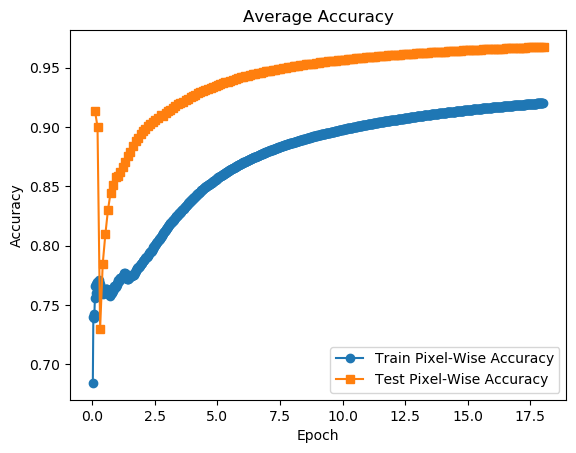

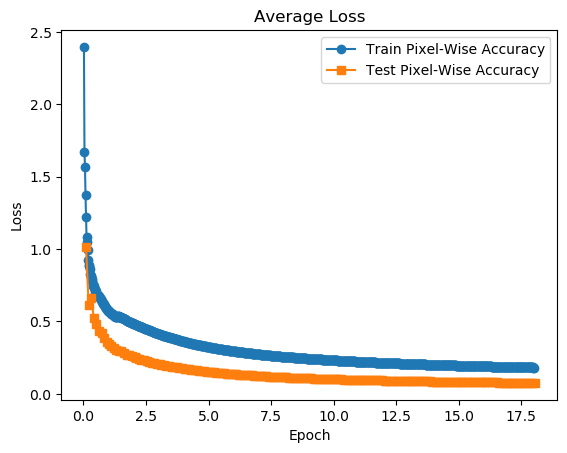

In [ ]:
plt.plot(total_updater.train_epoch, total_updater.train_avr_acc, label='Train Pixel-Wise Accuracy', marker='o', linestyle='-')
plt.plot(total_updater.test_epoch, total_updater.test_avr_acc, label='Test Pixel-Wise Accuracy', marker='s', linestyle='-')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy')

plt.legend()
plt.show()


plt.plot(total_updater.train_epoch, total_updater.train_avr_loss, label='Train Pixel-Wise Accuracy', marker='o', linestyle='-')
plt.plot(total_updater.test_epoch, total_updater.test_avr_loss, label='Test Pixel-Wise Accuracy', marker='s', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss')

plt.legend()
plt.show()

Accuracy Scores

In [ ]:
print('average sample test accuracy per epoch')
total_updater.test_avr_acc_epoch

average sample test accuracy per epoch


[0.8589862823486328,
 0.9344002210176908,
 0.9478430234468901,
 0.9645480376023512,
 0.9703149795532227,
 0.9773800483116737,
 0.9772905643169697,
 0.978467398423415,
 0.9782798767089844,
 0.9802372125478891,
 0.9800003198476939,
 0.9803379058837891,
 0.9817066045907827,
 0.9799673080444335,
 0.9828927260178787,
 0.9812270678006685,
 0.9826130646925707,
 0.9800407409667968]

In [ ]:
final_test_batch_iterator = iter(testLoader)
batch_accuracies = []
tn_count = 0
fp_count = 0
fn_count = 0
tp_count = 0

while True:
    try:
        model.eval()
        next_test_batch = next(final_test_batch_iterator)
        
        test_pixel_values = next_test_batch[0].to(device)
        test_labels = next_test_batch[1].to(device)
        test_outputs = model(pixel_values=test_pixel_values, labels=test_labels)
        test_upsampled_logits = nn.functional.interpolate(test_outputs.logits, size=test_labels.shape[-2:], mode="bilinear", align_corners=False)
        test_predicted = test_upsampled_logits.argmax(dim=1)
        test_mask = (test_labels != -1) # don't include the background class in the accuracy calculation
        test_pred_labels = test_predicted[test_mask].detach().cpu().numpy()
        test_true_labels = test_labels[test_mask].detach().cpu().numpy()
        
        test_accuracy = accuracy_score(test_pred_labels, test_true_labels)
        batch_accuracies.append(test_accuracy)

        conf_matrix = confusion_matrix(test_pred_labels, test_true_labels)
        tn, fp, fn, tp = conf_matrix.ravel()
        tn_count += tn
        fp_count += fp
        fn_count += fn
        tp_count += tp



    except StopIteration:
        break

iou = tp_count/(tp_count+fp_count+fn_count)
iou0 = tn_count/(tn_count+fn_count+fp_count)

print(f'pixel-wise accuracy: {sum(batch_accuracies)/len(batch_accuracies)}')
print(f'TN: {tn_count}, FP: {fp_count}, FN: {fn_count}, TP: {tp_count}')
print(f'precision: {tp_count/(tp_count+fp_count)}')
print(f'recall: {tp_count/(tp_count+fn_count)}')
print(f'iou (1 class): {iou}')
print(f'iou (0 class): {iou0}')
print(f'miou: {0.5*(iou+iou0)}')

pixel-wise accuracy: 0.9820740829558061
TN: 5988538, FP: 60328, FN: 61040, TP: 607534
precision: 0.9096699617585668
recall: 0.908701205850063
iou (1 class): 0.8334920195033078
iou (0 class): 0.980135864610683
miou: 0.9068139420569954


Hugging Face Upload

In [ ]:
# model.save_pretrained("segformer-b5-finetuned-mangrove-128-128") #save weights to folder

In [ ]:
# model.save_model("./my_model")

# with open('auth_token.txt', 'r') as file:
#     auth_token = file.read().strip()

# model.save_model("mpham8/segformer-b5-finetuned-mangrove-128-128", use_auth_token=auth_token)

Inference

In [ ]:
model.eval()
next_test_batch = next(test_batch)
test_pixel_values = next_test_batch[0].to(device)
test_labels = next_test_batch[1].to(device)
test_outputs = model(pixel_values=test_pixel_values, labels=test_labels)
test_upsampled_logits = nn.functional.interpolate(test_outputs.logits, size=test_labels.shape[-2:], mode="bilinear", align_corners=False)
test_predicted = test_upsampled_logits.argmax(dim=1)
test_mask = (test_labels != -1) # don't include the background class in the accuracy calculation
test_pred_labels = test_predicted[test_mask].detach().cpu().numpy()
test_true_labels = test_labels[test_mask].detach().cpu().numpy()
test_accuracy = accuracy_score(test_pred_labels, test_true_labels)

In [ ]:
reshaped_true = test_true_labels.reshape(BATCH_SIZE, INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT)
reshaped_pred = test_pred_labels.reshape(BATCH_SIZE, INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT)
rgb_pixels = test_pixel_values.detach().cpu().numpy()[:, 0:3,:,:]
rgb_pixels = rearrange(rgb_pixels, "b c w h -> b w h c")/np.max(rgb_pixels)

satellite image (3 bands only)


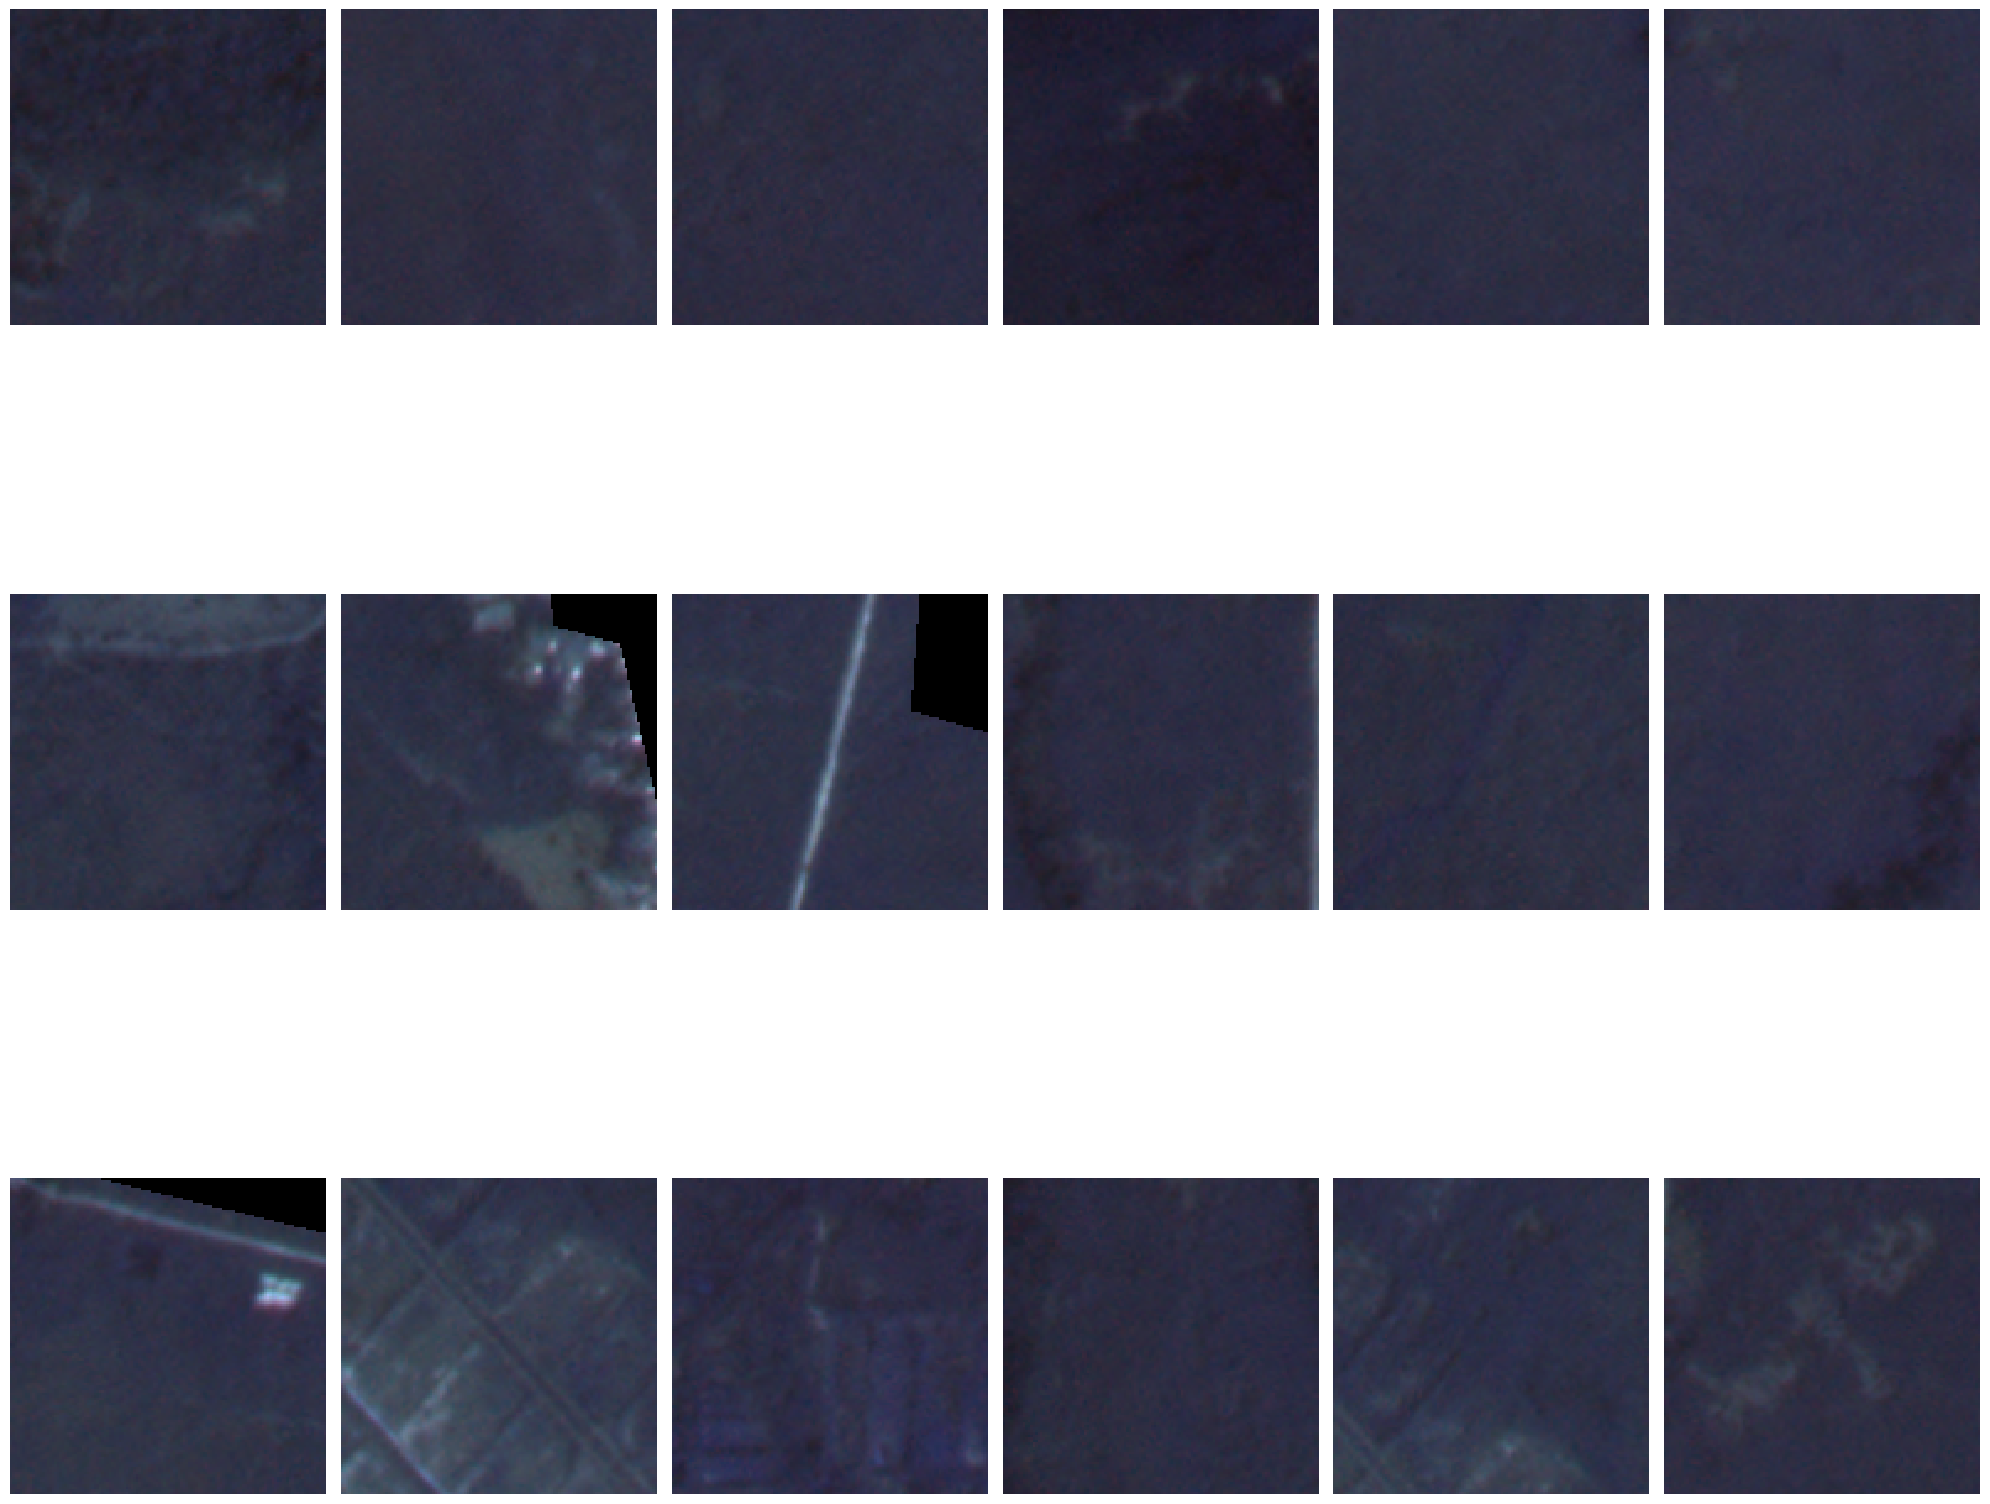

satellite image with predicted mask


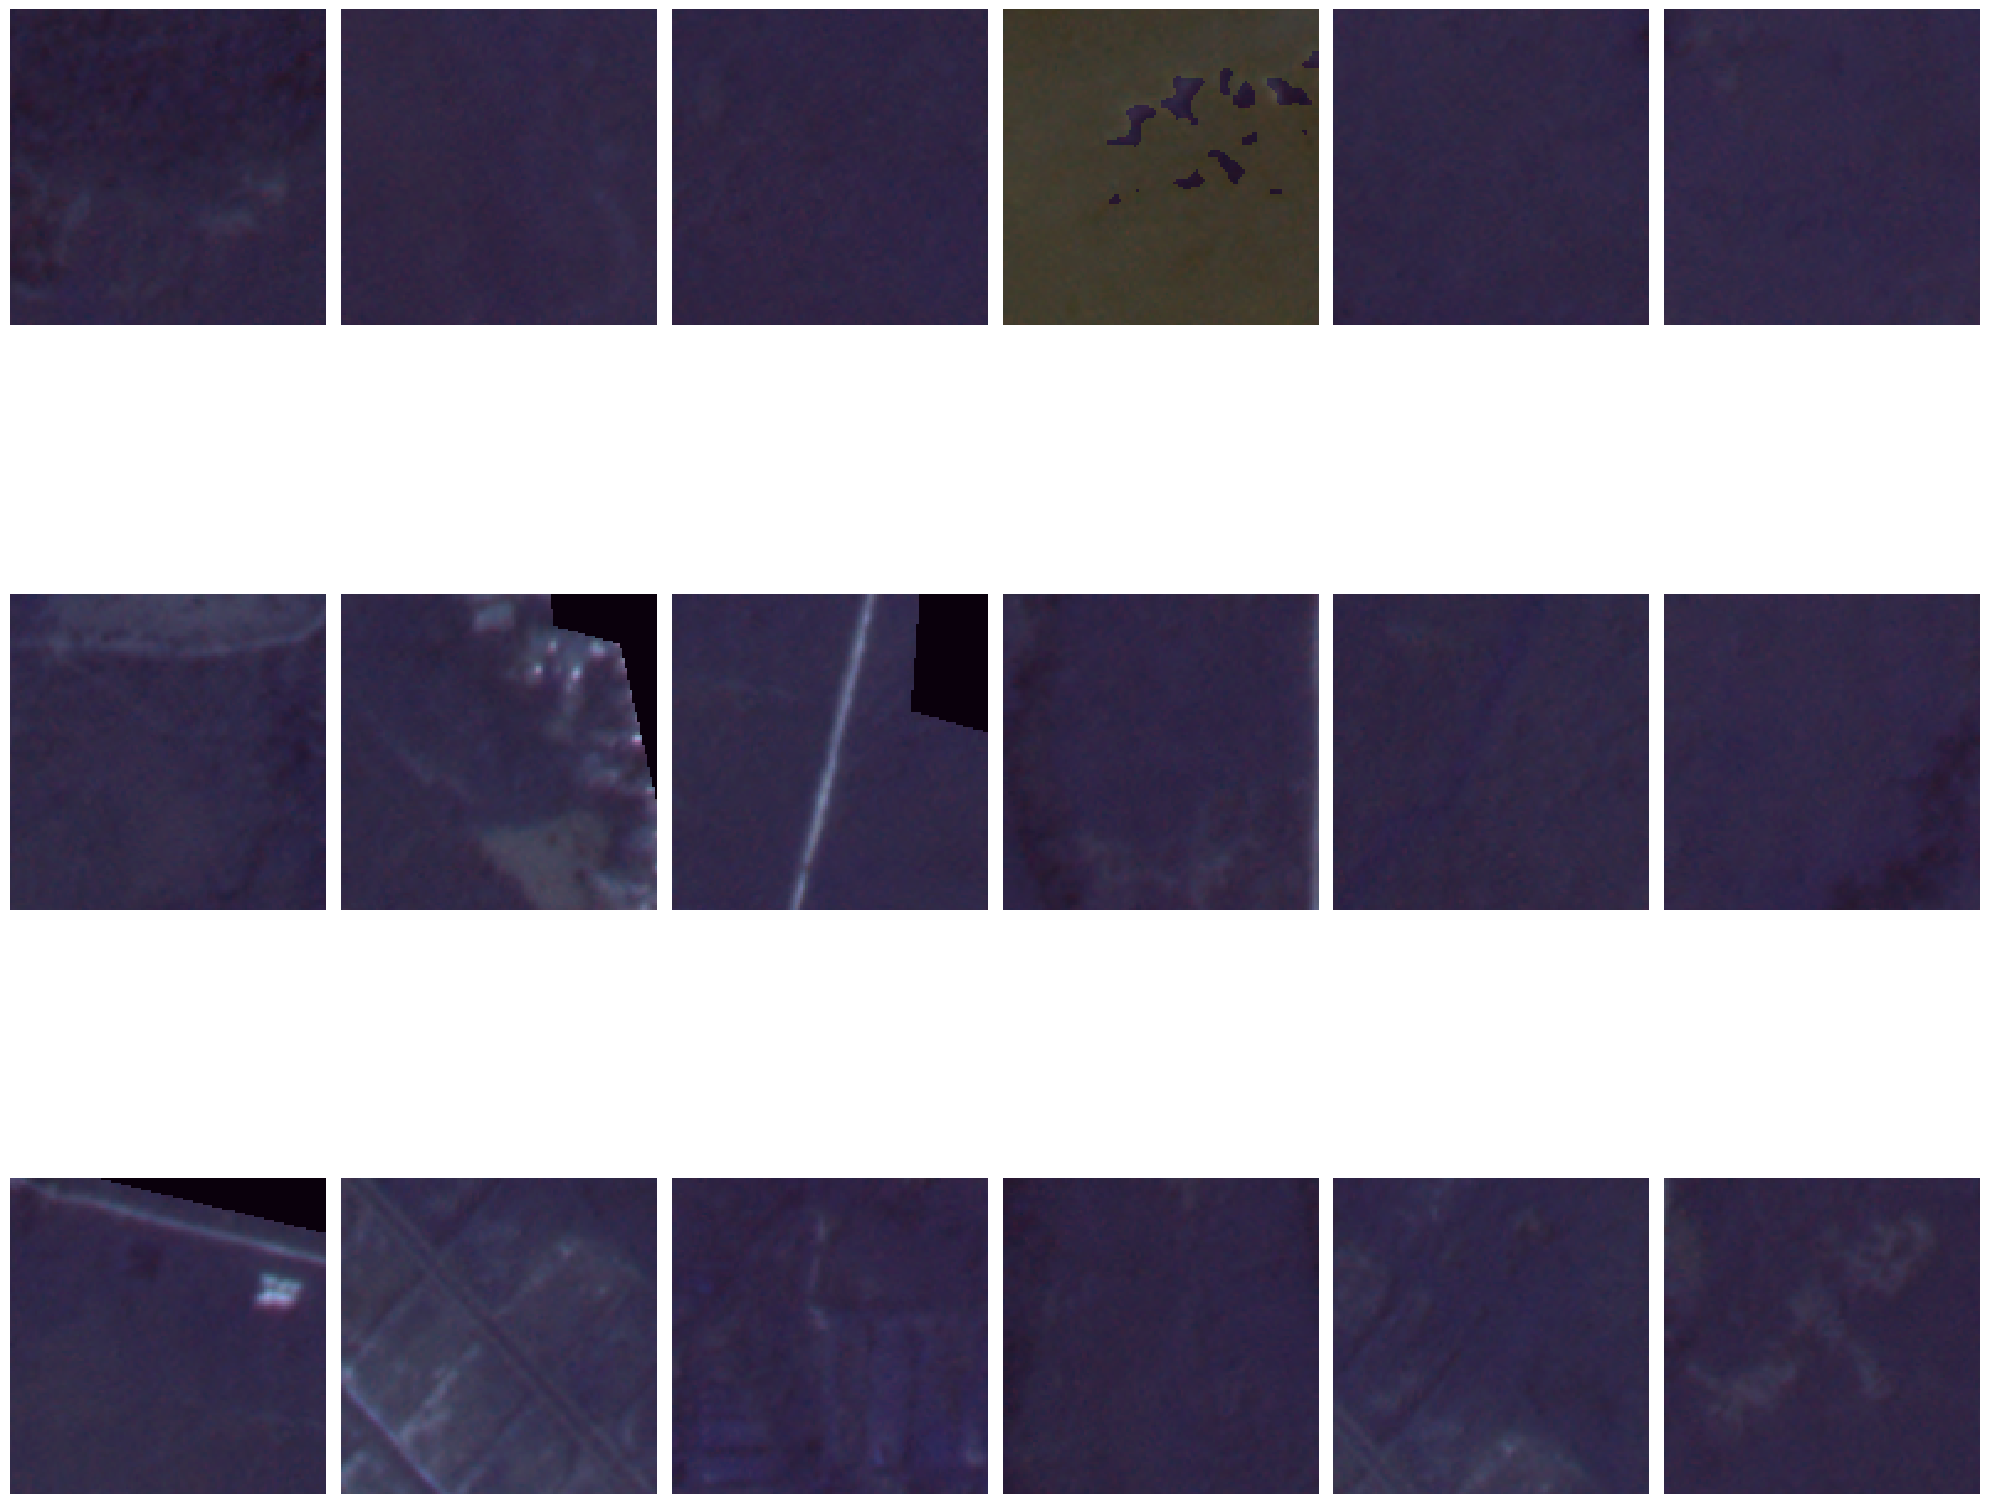

satellite image with true mask


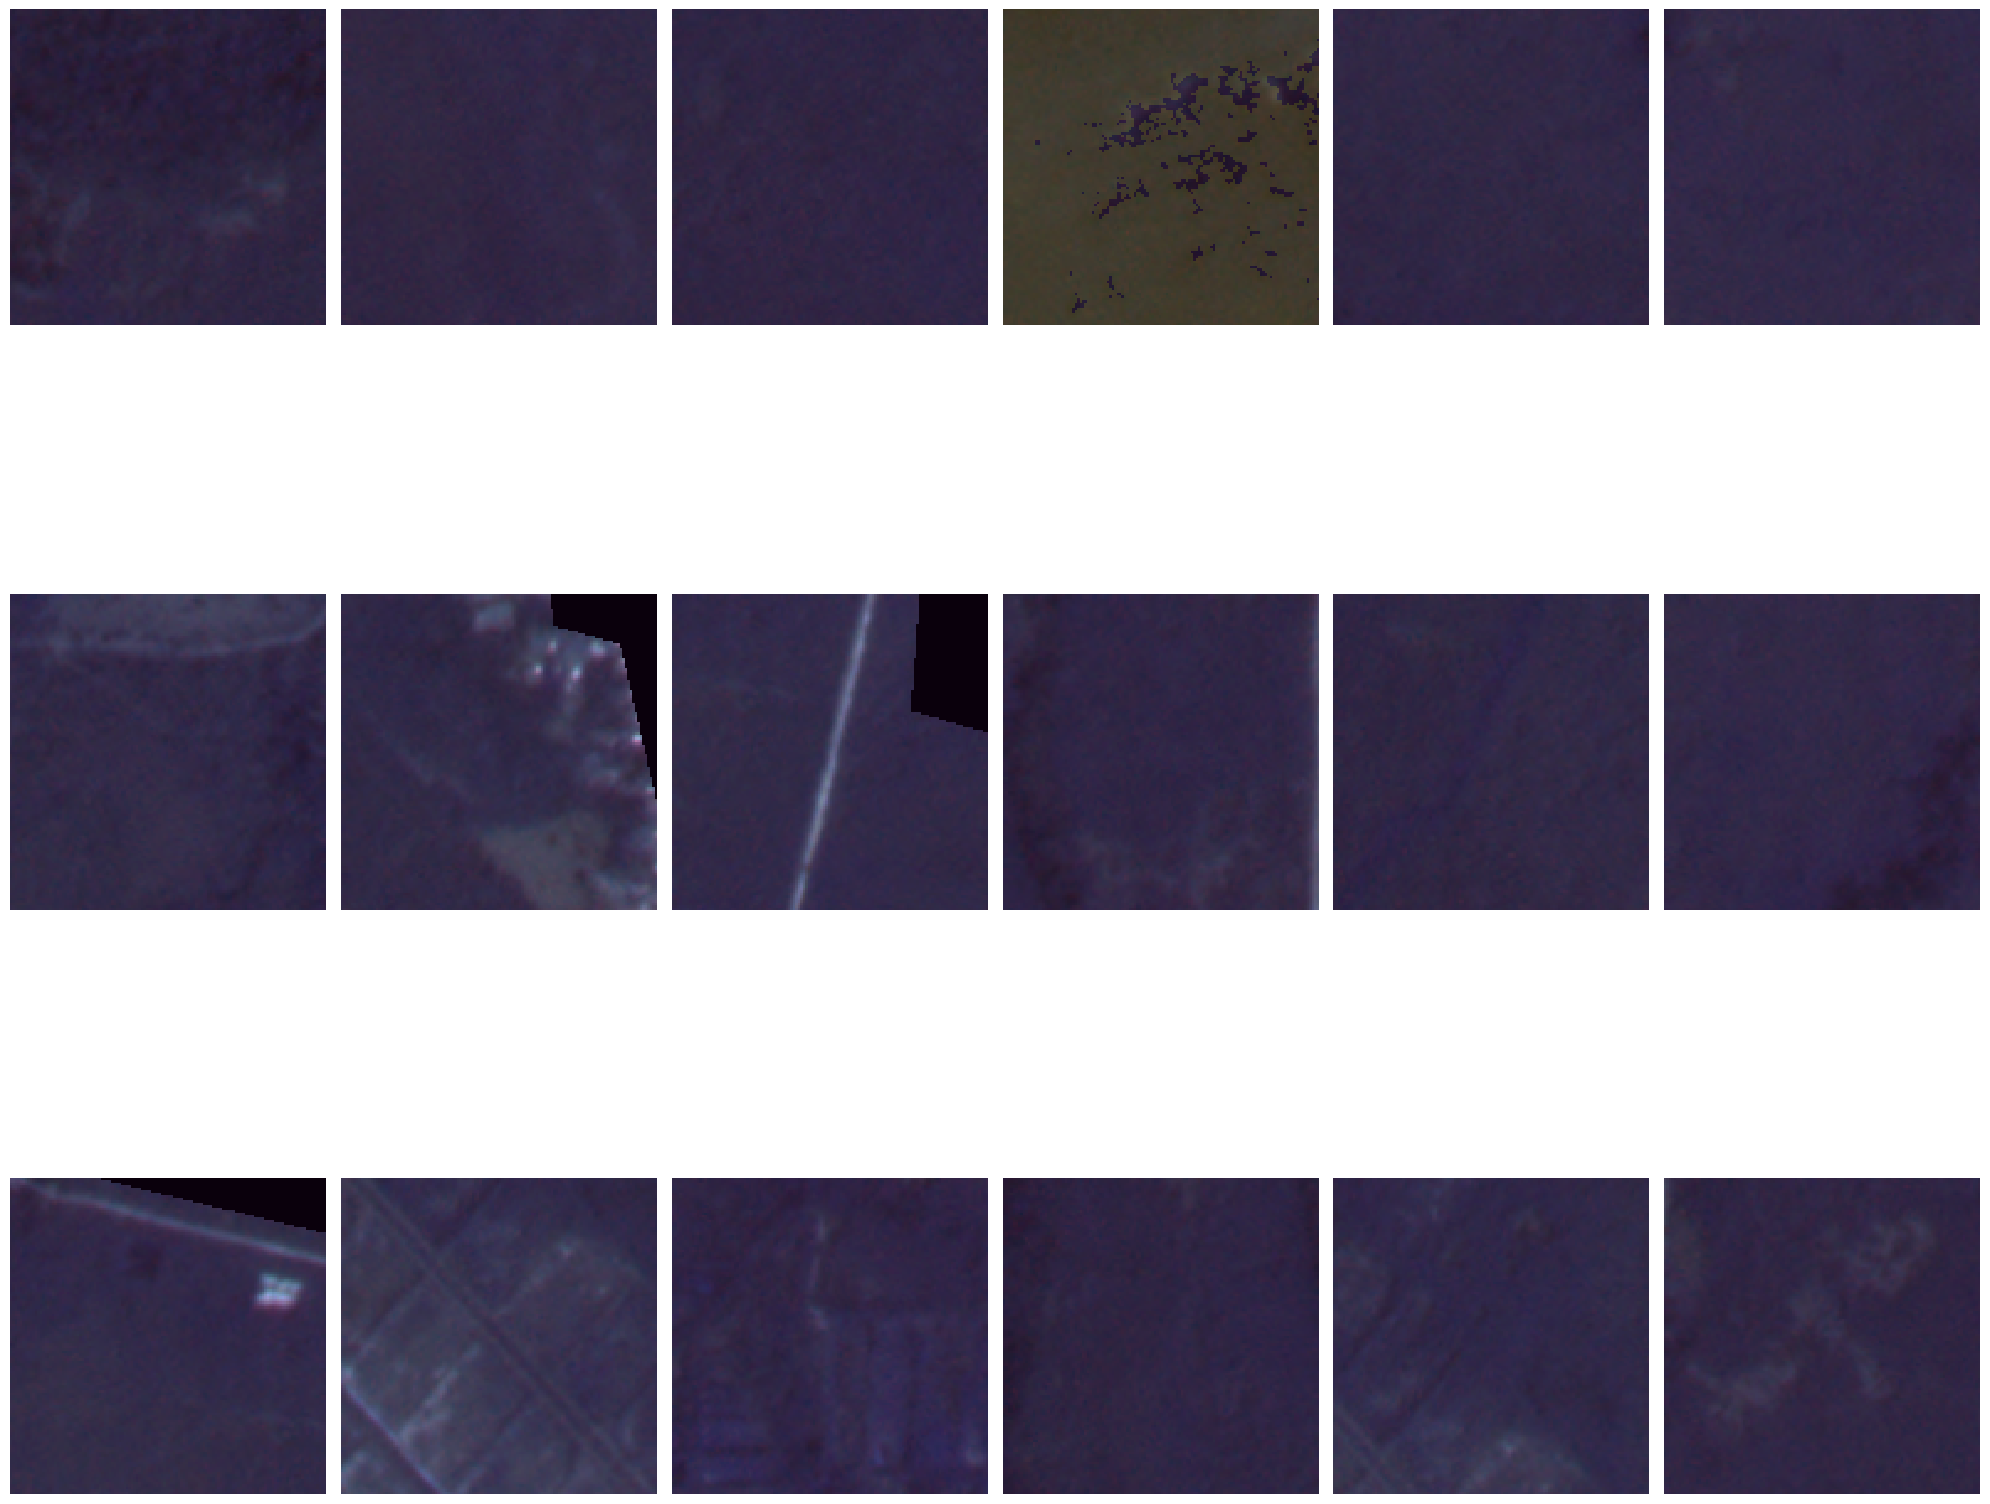

In [ ]:
num_rows = 3
num_cols = 6

print('satellite image (3 bands only)')
# Create a new figure with multiple subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,20))

# Loop through the images and masks and display them in the subplots
for i in range(num_rows*num_cols):
    img = rgb_pixels[i]

    # Plot the image
    axes[i // num_cols, i % num_cols].imshow(img)

    # Turn off axis ticks and labels for cleaner visualization
    axes[i // num_cols, i % num_cols].axis('off')

# Display the subplots
plt.tight_layout()
plt.show()



print('satellite image with predicted mask')
# Create a new figure with multiple subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,20))

# Loop through the images and masks and display them in the subplots
for i in range(num_rows*num_cols):
    img = rgb_pixels[i]
    mask = reshaped_pred[i]

    # Plot the image
    axes[i // num_cols, i % num_cols].imshow(img)

    # Overlay the mask on the image with transparency (alpha value)
    # If the mask is binary (0 and 1), you can set alpha=0.5 to make the mask semi-transparent
    axes[i // num_cols, i % num_cols].imshow(mask, alpha=0.15, cmap='viridis')

    # Turn off axis ticks and labels for cleaner visualization
    axes[i // num_cols, i % num_cols].axis('off')

# Display the subplots
plt.tight_layout()
plt.show()


print('satellite image with true mask')
# Create a new figure with multiple subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,20))

# Loop through the images and masks and display them in the subplots
for i in range(num_rows*num_cols):
    img = rgb_pixels[i]
    mask = reshaped_true[i]

    # Plot the image
    axes[i // num_cols, i % num_cols].imshow(img)

    # Overlay the mask on the image with transparency (alpha value)
    # If the mask is binary (0 and 1), you can set alpha=0.5 to make the mask semi-transparent
    axes[i // num_cols, i % num_cols].imshow(mask, alpha=0.15, cmap='viridis')

    # Turn off axis ticks and labels for cleaner visualization
    axes[i // num_cols, i % num_cols].axis('off')

# Display the subplots
plt.tight_layout()
plt.show()